In [1]:
import spacy
nlp = spacy.blank('id')
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
import re
import string
nltk.download('punkt')

komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from gensim.models.fasttext import FastText
model = FastText.load('Model/XGB.bin')

In [7]:
from MeanVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [8]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [12]:
weights = y_train_enc
weights = np.choose(weights, [1, 1.2, 1.1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.  1.  1.2 ... 1.2 1.1 1.1] 

Ini y_train_encode
 [0 0 1 ... 1 2 2] 



In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000
    
param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

# param['num_class']=len(set(y))
# param['learning_rate'] = 0.001
# param['max_depth'] = 7
# param['min_child_weight'] = 10
# param['gamma'] = 2
# param['reg_alpha'] = 0.9
# param['reg_lambda'] = 4
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['objective'] = 'multi:softmax'
# param['scale_pos_weight'] = 1

watchlist = [(train, 'train'), (test, 'test')]
# num_round = 100
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.39128	test-merror:0.56501
[1]	train-merror:0.30075	test-merror:0.55377
[2]	train-merror:0.24067	test-merror:0.53451
[3]	train-merror:0.22321	test-merror:0.51204
[4]	train-merror:0.19453	test-merror:0.50401
[5]	train-merror:0.17089	test-merror:0.48957
[6]	train-merror:0.14666	test-merror:0.48154
[7]	train-merror:0.14110	test-merror:0.47352
[8]	train-merror:0.11918	test-merror:0.45265
[9]	train-merror:0.10992	test-merror:0.46228
[10]	train-merror:0.10352	test-merror:0.45746
[11]	train-merror:0.09316	test-merror:0.45586
[12]	train-merror:0.08936	test-merror:0.45746
[13]	train-merror:0.08504	test-merror:0.46067
[14]	train-merror:0.07959	test-merror:0.45425
[15]	train-merror:0.08043	test-merror:0.46388
[16]	train-merror:0.07827	test-merror:0.46549
[17]	train-merror:0.07725	test-merror:0.45586
[18]	train-merror:0.07725	test-merror:0.46228
[19]	train-merror:0.07179	test-merror:0.45746
[20]	train-merror:0.06598	test-merror:0.45425
[21]	train-merror:0.06696	test-merror:0.4574

[177]	train-merror:0.01101	test-merror:0.41734
[178]	train-merror:0.01098	test-merror:0.41413
[179]	train-merror:0.01178	test-merror:0.41573
[180]	train-merror:0.01142	test-merror:0.41413
[181]	train-merror:0.01098	test-merror:0.41573
[182]	train-merror:0.01142	test-merror:0.41734
[183]	train-merror:0.01182	test-merror:0.41573
[184]	train-merror:0.01142	test-merror:0.41734
[185]	train-merror:0.01105	test-merror:0.41734
[186]	train-merror:0.01017	test-merror:0.41573
[187]	train-merror:0.00973	test-merror:0.41573
[188]	train-merror:0.01054	test-merror:0.41894
[189]	train-merror:0.01054	test-merror:0.41573
[190]	train-merror:0.01054	test-merror:0.41573
[191]	train-merror:0.01054	test-merror:0.41413
[192]	train-merror:0.01017	test-merror:0.41252
[193]	train-merror:0.01017	test-merror:0.41573
[194]	train-merror:0.01017	test-merror:0.41252
[195]	train-merror:0.01098	test-merror:0.41573
[196]	train-merror:0.01017	test-merror:0.41734
[197]	train-merror:0.00944	test-merror:0.41091
[198]	train-m

[352]	train-merror:0.00212	test-merror:0.39968
[353]	train-merror:0.00168	test-merror:0.39807
[354]	train-merror:0.00168	test-merror:0.39807
[355]	train-merror:0.00168	test-merror:0.39807
[356]	train-merror:0.00212	test-merror:0.39807
[357]	train-merror:0.00212	test-merror:0.39807
[358]	train-merror:0.00212	test-merror:0.39968
[359]	train-merror:0.00212	test-merror:0.39968
[360]	train-merror:0.00212	test-merror:0.40128
[361]	train-merror:0.00212	test-merror:0.40128
[362]	train-merror:0.00212	test-merror:0.40289
[363]	train-merror:0.00212	test-merror:0.39968
[364]	train-merror:0.00212	test-merror:0.40128
[365]	train-merror:0.00212	test-merror:0.39968
[366]	train-merror:0.00168	test-merror:0.39968
[367]	train-merror:0.00168	test-merror:0.39807
[368]	train-merror:0.00124	test-merror:0.39968
[369]	train-merror:0.00124	test-merror:0.39647
[370]	train-merror:0.00124	test-merror:0.39968
[371]	train-merror:0.00124	test-merror:0.40128
[372]	train-merror:0.00084	test-merror:0.39968
[373]	train-m

[527]	train-merror:0.00040	test-merror:0.39647
[528]	train-merror:0.00040	test-merror:0.39647
[529]	train-merror:0.00040	test-merror:0.39647
[530]	train-merror:0.00040	test-merror:0.39647
[531]	train-merror:0.00040	test-merror:0.39968
[532]	train-merror:0.00040	test-merror:0.39968
[533]	train-merror:0.00040	test-merror:0.39968
[534]	train-merror:0.00040	test-merror:0.39807
[535]	train-merror:0.00040	test-merror:0.39968
[536]	train-merror:0.00040	test-merror:0.39807
[537]	train-merror:0.00040	test-merror:0.39807
[538]	train-merror:0.00040	test-merror:0.39807
[539]	train-merror:0.00040	test-merror:0.39807
[540]	train-merror:0.00040	test-merror:0.39647
[541]	train-merror:0.00040	test-merror:0.39647
[542]	train-merror:0.00040	test-merror:0.39807
[543]	train-merror:0.00040	test-merror:0.39807
[544]	train-merror:0.00040	test-merror:0.39807
[545]	train-merror:0.00040	test-merror:0.39807
[546]	train-merror:0.00040	test-merror:0.39807
[547]	train-merror:0.00040	test-merror:0.39807
[548]	train-m

[702]	train-merror:0.00000	test-merror:0.39486
[703]	train-merror:0.00000	test-merror:0.39326
[704]	train-merror:0.00000	test-merror:0.39486
[705]	train-merror:0.00000	test-merror:0.39326
[706]	train-merror:0.00000	test-merror:0.39326
[707]	train-merror:0.00000	test-merror:0.39326
[708]	train-merror:0.00000	test-merror:0.39486
[709]	train-merror:0.00000	test-merror:0.39326
[710]	train-merror:0.00000	test-merror:0.39326
[711]	train-merror:0.00000	test-merror:0.39486
[712]	train-merror:0.00000	test-merror:0.39647
[713]	train-merror:0.00000	test-merror:0.39486
[714]	train-merror:0.00000	test-merror:0.39486
[715]	train-merror:0.00000	test-merror:0.39486
[716]	train-merror:0.00000	test-merror:0.39326
[717]	train-merror:0.00000	test-merror:0.39486
[718]	train-merror:0.00000	test-merror:0.39326
[719]	train-merror:0.00000	test-merror:0.39326
[720]	train-merror:0.00000	test-merror:0.39326
[721]	train-merror:0.00000	test-merror:0.39326
[722]	train-merror:0.00000	test-merror:0.39326
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.39326
[878]	train-merror:0.00000	test-merror:0.39326
[879]	train-merror:0.00000	test-merror:0.39486
[880]	train-merror:0.00000	test-merror:0.39326
[881]	train-merror:0.00000	test-merror:0.39326
[882]	train-merror:0.00000	test-merror:0.39326
[883]	train-merror:0.00000	test-merror:0.39326
[884]	train-merror:0.00000	test-merror:0.39326
[885]	train-merror:0.00000	test-merror:0.39486
[886]	train-merror:0.00000	test-merror:0.39486
[887]	train-merror:0.00000	test-merror:0.39486
[888]	train-merror:0.00000	test-merror:0.39486
[889]	train-merror:0.00000	test-merror:0.39486
[890]	train-merror:0.00000	test-merror:0.39486
[891]	train-merror:0.00000	test-merror:0.39326
[892]	train-merror:0.00000	test-merror:0.39326
[893]	train-merror:0.00000	test-merror:0.39165
[894]	train-merror:0.00000	test-merror:0.39165
[895]	train-merror:0.00000	test-merror:0.39165
[896]	train-merror:0.00000	test-merror:0.39165
[897]	train-merror:0.00000	test-merror:0.39326
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6067415730337079 

Train Score
 1.0 

CONFUSSION MATRIX
 [[158  43  19]
 [ 51 108  41]
 [ 36  55 112]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.64      0.72      0.68       220
      netral       0.52      0.54      0.53       200
     positif       0.65      0.55      0.60       203

    accuracy                           0.61       623
   macro avg       0.61      0.60      0.60       623
weighted avg       0.61      0.61      0.61       623
 



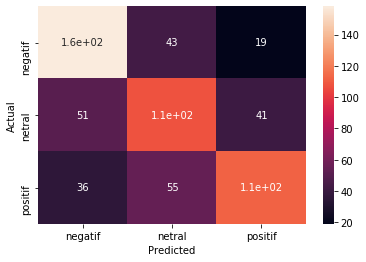

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])